# Imaging at large angles

In [169]:
from pylab import *
import numpy as np
from astropy.io import fits
from astropy.coordinates import SkyCoord, Angle
import astropy.units as units
from craco.search_pipeline import location2pix, get_grid_lut_from_plan, grid_candidates,wait_for_starts,waitall,print_candidates
from craco.search_pipeline import NBINARY_POINT_FDMTIN 
import craco
import craco.search_pipeline
from craco.pyxrtutil import *
import craft.craco_plan

from craft import uvfits

from craft.craco_plan import PipelinePlan
from craft.craco import printstats
import logging
import time

%matplotlib notebook

In [2]:
ls /data/craco/ban115/test_data/

ddgrid/                       frb_d0_t3_a1_sninf_lm00/      nant20@
frb_d0_t0_a1_sn10_lm00/       frb_d0_t4_a1_sninf_lm00/      nant3/
frb_d0_t0_a1_sninf_lm00/      frb_d0_t9_a1_sninf_lm00/      nant30/
frb_d0_t0_a1_sninf_lm100200/  frb_d2_t0_a1_sninf_lm00/      nant36/
frb_d0_t0_a2_sninf_lm00/      frb_d2_t4_a1_sn10_lm300400/   old_tranpose/
frb_d0_t1_a1_sninf_lm00/      frb_d2_t4_a1_sninf_lm300400/  transpose_31204/
frb_d0_t2_a1_sninf_lm00/      frb_d3_t7_a1_sninf_lm00/


In [220]:
fits='/data/craco/ban115/test_data/frb_d0_t0_a1_sninf_lm00/frb_d0_t0_a1_sninf_lm00.fits'
fits = '/data/craco/ban115/test_data/frb_d0_t0_a1_sninf_lm100200/frb_d0_t0_a1_sninf_lm100200.fits'

# PSR B1933+16 data
fits = '/data/craco/ban115/craco-python/notebooks/data/SB049048v2/cap_spi16_bm0_a1-12_k1-6_ps_tsoff/results/b00.uvfits'
#fits='/data/craco/ban115/test_data/nant3/frb_d0_t0_a1_sninf_lm00/frb_d0_t0_a1_sninf_lm00.fits'
values = craco.search_pipeline.get_parser().parse_args([])
print(values)
f = uvfits.open(fits)
plan = PipelinePlan(f, "--ndm 2 --max-nbl 465 ")

Namespace(boxcar_weight='sum', calibration=None, cand_file='candidates.txt', cell=None, device=0, dump_boxcar_hist_buf=None, dump_candidates=None, dump_fdmt_hist_buf=None, dump_input=None, dump_mainbufs=None, dump_uvdata=None, fdmt_scale=1.0, fft_scale=10.0, fft_shift1=0, fft_shift2=0, flag_ants=None, flag_chans=None, injection_file=None, input_scale=1.0, max_ndm=1024, nblocks=None, nbox=8, ncin=32, ndm=512, ndout=186, npix=256, nt=256, nuvmax=8192, nuvwide=8, os='2.1,2.1', phase_center_filterbank=None, print_dm0_stats=False, run_fdmt=True, run_image=True, show=False, show_candidate_grid=None, skip_blocks=0, subtract=True, target_input_rms=512, threshold=10.0, uv=None, verbose=False, wait=False, xclbin='binary_container_1.xclbin.golden')
parsing values --ndm 2 --max-nbl 465 


/data/craco/ban115/craft-github/src/craft/uvfits.py:195: UserWarning: Dont yet support multiple source files: 2 - using source at 2 which is (2, 'CRACO_B1933+16_beam0', 0, '', 0.0, 0.0, 0.0, 0.0, 0.0, 47.999999999999815, 293.94875, 16.277786111111123, 2000.0, 293.94875, 16.277786111111123, 0.0, 0.0, 0.0, 0.0)
  warnings.warn(f'Dont yet support multiple source files: {len(source_table)} - using source at {first_targetidx} which is {row}')
/data/craco/ban115/craft-github/src/craft/craco_plan.py:140: UserWarning: Cannot grid things on U=0 or V=0 blid=258.0 1-2 uvpix=(255, 0)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/data/craco/ban115/craft-github/src/craft/craco_plan.py:140: UserWarning: Cannot grid things on U=0 or V=0 blid=516.0 2-4 uvpix=(0, 254)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/data/craco/ban115/craft-github/src/craft/craco_plan.py:140: UserWarning: Cannot grid things on U=0 or V=0

Upper registers [(2, 1), (3, 1), (18, 1), (19, 1), (46, 1), (47, 1), (48, 1), (49, 1), (213, 1), (214, 1), (215, 1), (216, 1), (233, 1), (234, 1), (239, 1), (240, 1), (246, 1), (253, 1), (254, 1), (255, 1), (10, 2), (11, 2), (19, 2), (20, 2), (21, 2), (24, 2), (25, 2), (29, 2), (30, 2), (31, 2), (49, 2), (50, 2)]
Lower registers [(1, 2), (2, 5), (2, 7), (1, 10), (5, 10), (9, 10), (1, 11), (3, 11), (6, 11), (2, 12), (3, 12), (6, 12), (2, 13), (3, 13), (4, 13), (6, 13), (8, 13), (9, 13), (10, 13), (3, 14), (4, 14), (6, 14), (9, 14), (10, 14), (11, 14), (12, 14), (13, 14), (1, 15), (5, 15), (9, 15), (11, 15), (13, 15)]


In [221]:
def pointsource(amp, lm, plan, noiseamp=0):
    '''
    Returns simulted visibilities for a point source with given amplitude at given value of lm =(l, m) in radians
    offset from the phase center
        
    :amp: amplitude
    :lm: tuple of l,m as direction cosines i.e. l=sin(psi), m=sin(theta)
    :plan: craco_plan to get all the goodies like UVWs and stuff from
    :noiseamp: add nois with tgiven ampliutude
    :returns: np.array of complex dtype with shape (nbl, nchan)
    '''
    nbl = plan.nbl
    freqs = plan.freqs
    nf = len(freqs)
    assert np.all(freqs > 500e6), 'Invalid frequencies'
    
    l, m = lm
    dout = np.empty((nbl, nf), dtype=np.complex64)
    for ibl, blid in enumerate(plan.baseline_order):       
        # baselines in seconds
        uvw_sec = np.array(plan.baselines[blid][:3])
        
        # convert UVW coordinates to wavelegths
        u = uvw_sec[0]*freqs
        v = uvw_sec[1]*freqs
        w = uvw_sec[2]*freqs

        # TMS equation 3.7 - don't include 1/sqrt(1 - l*l - m*m) denomiator term for point sources
        vis = amp*np.exp(-2j*np.pi*(u*l + v*m + w*(np.sqrt(1.0 - l*l - m*m) - 1.0)))
        if noiseamp > 0:
            vishape = vis.shape
            noise = noiseamp*(np.random.randn(*vishape) + 1j*np.random.randn(*vishape))
            vis += noise

        dout[ibl, :] = vis

    return dout

In [222]:
lm = (0,0.1)
lmarcsec = np.array((100,200))
lm = np.sin(np.radians(lmarcsec/3600))
lm=(0.01,0.02)
lm = np.sin(np.radians([0.5,0.5]))
vissim = pointsource(1, lm, plan)
print('lm', lm)

lm [0.00872654 0.00872654]


<IPython.core.display.Javascript object>


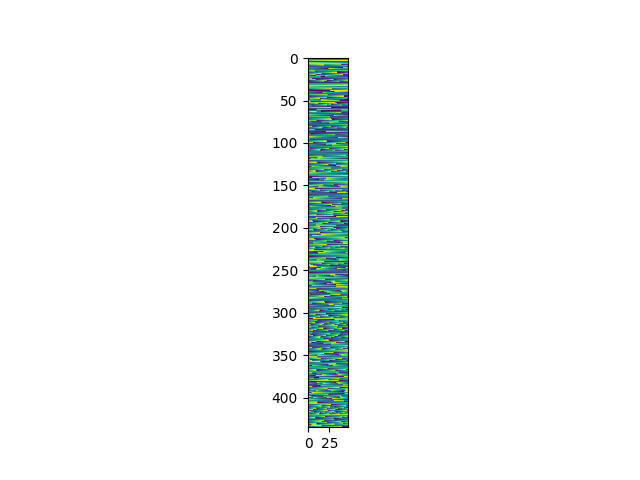

In [223]:
figure()
imshow(np.angle(vissim))

In [225]:
uvws = []
freqs = plan.freqs

for ibl, blid in enumerate(plan.baseline_order):       
    # baselines in seconds
    uvw_sec = np.array(plan.baselines[blid][:3])

    # convert UVW coordinates to wavelegths
    u = uvw_sec[0]*freqs
    v = uvw_sec[1]*freqs
    w = uvw_sec[2]*freqs
    uvws.append((u,v,w))
    
uvws = np.array(uvws)
uvws.shape

(435, 3, 48)

<IPython.core.display.Javascript object>


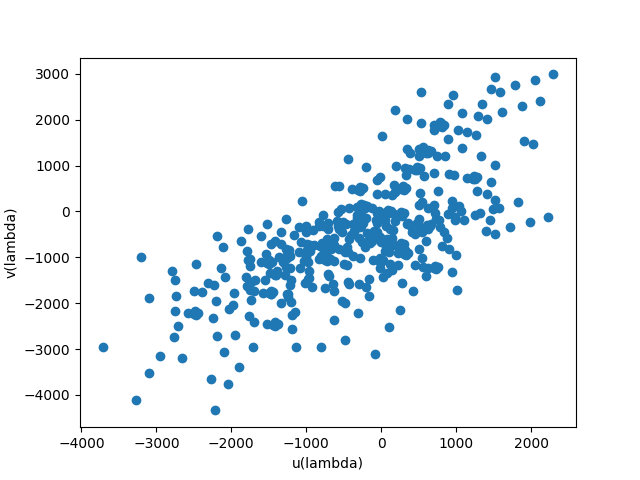

Text(0, 0.5, 'v(lambda)')

In [226]:
figure()
scatter(uvws[:,0,0],uvws[:,1,0])
xlabel('u(lambda)')
ylabel('v(lambda)')


<IPython.core.display.Javascript object>


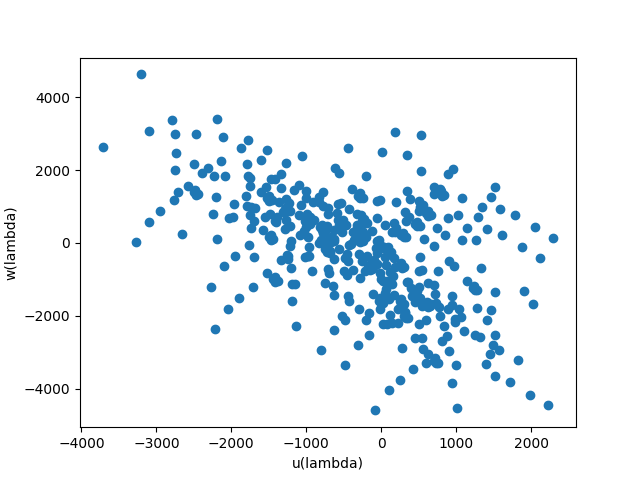

Text(0, 0.5, 'w(lambda)')

In [227]:
figure()
scatter(uvws[:,0,0],uvws[:,2,0])
xlabel('u(lambda)')
ylabel('w(lambda)')

<IPython.core.display.Javascript object>


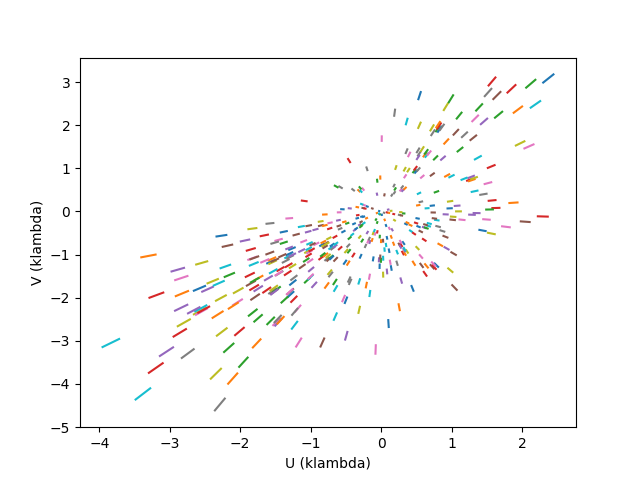

In [229]:
figure()
f.plot_baselines()

In [232]:
f.baselines.keys()


dict_keys([258.0, 259.0, 260.0, 261.0, 262.0, 263.0, 264.0, 265.0, 266.0, 267.0, 268.0, 269.0, 270.0, 271.0, 272.0, 273.0, 274.0, 275.0, 276.0, 277.0, 278.0, 279.0, 280.0, 281.0, 282.0, 283.0, 284.0, 285.0, 286.0, 515.0, 516.0, 517.0, 518.0, 519.0, 520.0, 521.0, 522.0, 523.0, 524.0, 525.0, 526.0, 527.0, 528.0, 529.0, 530.0, 531.0, 532.0, 533.0, 534.0, 535.0, 536.0, 537.0, 538.0, 539.0, 540.0, 541.0, 542.0, 772.0, 773.0, 774.0, 775.0, 776.0, 777.0, 778.0, 779.0, 780.0, 781.0, 782.0, 783.0, 784.0, 785.0, 786.0, 787.0, 788.0, 789.0, 790.0, 791.0, 792.0, 793.0, 794.0, 795.0, 796.0, 797.0, 798.0, 1029.0, 1030.0, 1031.0, 1032.0, 1033.0, 1034.0, 1035.0, 1036.0, 1037.0, 1038.0, 1039.0, 1040.0, 1041.0, 1042.0, 1043.0, 1044.0, 1045.0, 1046.0, 1047.0, 1048.0, 1049.0, 1050.0, 1051.0, 1052.0, 1053.0, 1054.0, 1286.0, 1287.0, 1288.0, 1289.0, 1290.0, 1291.0, 1292.0, 1293.0, 1294.0, 1295.0, 1296.0, 1297.0, 1298.0, 1299.0, 1300.0, 1301.0, 1302.0, 1303.0, 1304.0, 1305.0, 1306.0, 1307.0, 1308.0, 1309.0, 1

In [233]:
d = f.baselines[258.0]
blid = d['BASELINE']
blid

258.0

In [234]:
u,v,w = d['UU'],d['VV'],d['WW']
freqs = plan.freqs
ulam, vlam, wlam = u*freqs, v*freqs, w*freqs


In [348]:
idx = np.where(plan.baseline_order == blid)[0][0]

In [349]:
vissim[idx,:].shape

(48,)

In [350]:
vissim.shape

(435, 48)

<IPython.core.display.Javascript object>


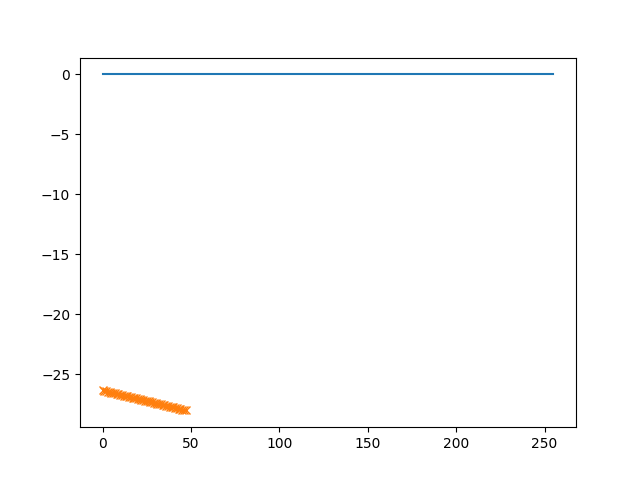

In [351]:
figure()
plot(np.degrees(np.angle(visc)))
plot(np.degrees(np.angle(np.conj(vissim[idx,:]))),'x')

<IPython.core.display.Javascript object>


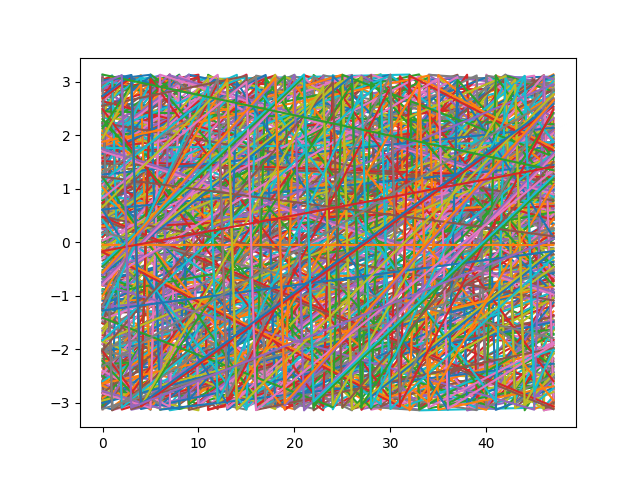

In [352]:
figure()
_ = plot(np.angle(vissim).T)

In [353]:
def grid(plan, din, uvcell, npix):
    nbl = plan.nbl
    freqs = plan.freqs
    nf = len(freqs)
    assert np.all(freqs > 500e6), 'Invalid frequencies'
        
    g = np.zeros((npix,npix), dtype=np.complex64)
    for ibl, blid in enumerate(plan.baseline_order):       
        # baselines in seconds
        uvw_sec = np.array(plan.baselines[blid][:3])
        
        # convert UVW coordinates to wavelegths
        u = uvw_sec[0]*freqs
        v = uvw_sec[1]*freqs
        #w = uvw_sec[2]*freqs
        
        #vis = np.exp(-2j*np.pi*(u*l + v*m + w*(np.sqrt(1.0 - l*l - m*m) - 1.0)))
        pivot = npix // 2
        upix = np.round(u/uvcell[0]).astype(int)
        vpix = np.round(v/uvcell[1]).astype(int)
        for ichan, (up,vp) in enumerate(zip(upix,vpix)):
            g[pivot+vp,pivot+up] += din[ibl,ichan]
            g[pivot-vp,pivot-up] += np.conj(din[ibl,ichan])
        

        
        
    return g

def doimage(g):
    return np.fft.fftshift(np.fft.fft2(np.fft.fftshift(g)))
    

In [354]:
plan.uvcell

(32.4283176545956, 37.8339129964643)

lm=[0.00872654 0.012217  ]


<IPython.core.display.Javascript object>


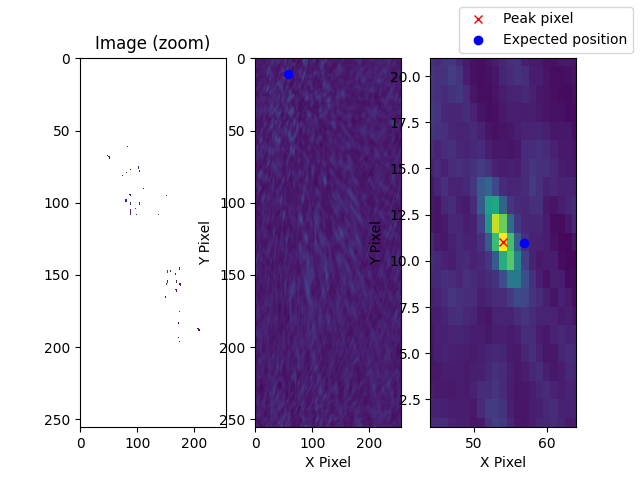

maxpix (11, 54)


In [379]:

# use plan cell size
uvcell = plan.uvcell

# use plan npix
npix=plan.npix

#    :lm: tuple of l,m as direction cosines i.e. l=sin(psi), m=sin(theta)
psi = Angle('0.5d') # offset degrees - RA direction
theta = Angle('0.7d') # offset degrees - dec direction
expected_dec = plan.phase_center.dec - theta # not sure why I need a negative here
# RA needs to be decremented by source cos dec
expected_ra = np.degrees(plan.phase_center.ra.rad + psi.rad/np.cos(expected_dec.rad))
expected_pos = SkyCoord(expected_ra, expected_dec, unit='deg')
# What did I expect the pixel location to be, given the expected position?
expected_pixel = plan.wcs.world_to_pixel(expected_pos)

lm = np.sin([psi.rad, theta.rad])
print(f'lm={lm}')
#lm=(0.01,0.02)
#lm = (0,0)
#lm = (0,0)
peak = 97280.0
vissim = pointsource(1, lm, plan)

fig,ax = subplots(1,3)
g = grid(plan, vissim, uvcell, npix)/np.prod(vissim.shape)/2 # Scales image to 1 for phase center
img = doimage(g)
gimg = abs(g)
gimg[gimg==0] = np.nan
maxpix = np.unravel_index(np.argmax(img.real), img.shape)
print('maxpix', maxpix)
ymax,xmax = maxpix
extents = (xmax -10, xmax+10, ymax-10, ymax+10)
#xtents=None
ax[0].imshow(gimg, aspect='auto')
ax[0].set_title("UV plane")

ax[1].imshow(img.real,aspect='auto')
ax[1].plot(xmax,ymax, 'rx')
ax[1].plot(expected_pixel[0], expected_pixel[1], 'bo')
ax[1].set_xlabel('X Pixel')
ax[1].set_ylabel('Y Pixel')
ax[0].set_title("Image")


ax[2].imshow(img.real,aspect='auto')
line1, = ax[2].plot(xmax,ymax, 'rx')
line2, = ax[2].plot(expected_pixel[0], expected_pixel[1], 'bo')
ax[2].set_xlabel('X Pixel')
ax[2].set_ylabel('Y Pixel')
ax[2].set_xlim(xmax-10,xmax+10)
ax[2].set_ylim(ymax-10,ymax+10)
ax[0].set_title("Image (zoom)")

figlegend((line1,line2),('Peak pixel','Expected position'))
        

In [380]:

import matplotlib.pyplot as plt
figure()
plt.subplot(projection=plan.wcs)
plt.imshow(img.real)
plt.grid(color='white', ls='solid')
plt.plot(xmax,ymax, 'rx')
plt.plot(expected_pixel[0], expected_pixel[1], 'bo')

<IPython.core.display.Javascript object>

In [364]:
plan.wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 293.94875  16.277786111111123  
CRPIX : 128.5  128.5  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.006901734499669926  0.005915635497282392  
NAXIS : 0  0

In [365]:
# there's some extra stuff in GETPV
plan.wcs.wcs.get_pv()

[(2, 1, -1.9725608379728206), (2, 2, 1.5582007215728193)]

In [366]:
# CRPIX is 128.5,128.5, but if you put do pixel_to_world(127.5,127.5) you get CRVAL back
# So there's a +-1 added because of the FITS convention. SIGH
plan.wcs.pixel_to_world(127.5,127.5)

<SkyCoord (ICRS): (ra, dec) in deg
    (293.94875, 16.27778611)>

In [367]:
wcs_pos = plan.wcs.pixel_to_world(xmax-1,ymax-1) 
wcs_pos

<SkyCoord (ICRS): (ra, dec) in deg
    (294.27269826, 15.87470363)>

In [368]:
expected_pos

<SkyCoord (ICRS): (ra, dec) in deg
    (294.26064977, 15.87778611)>

In [369]:
ra_err = expected_pos.ra - wcs_pos.ra
ra_err

<Angle -0.01204849 deg>

In [370]:
dec_err = expected_pos.dec - wcs_pos.dec
dec_err

<Angle 0.00308248 deg>

In [371]:
# image resolution
plan.lmcell.arcsec

array([24.8462442 , 21.29628779])

In [372]:
expected_pixel

(array(84.65596024), array(60.49606074))

In [373]:
xmax, ymax

(84, 61)

# Doing something else - check what changing cell size does to peak value

In [374]:


for c in (2,5,10,15,20,30,40):
    for npix in (256,512,1024,2048,4096):
        uvcell=(c,c)
        try:
            g = grid(plan, vissim, uvcell, npix)
            img = doimage(g)
            print(f'c={c} npix={npix} max={img.real.max()/peak}')
        except:
            print(f'Couldnt grid c={c} npix={npix}')
        

Couldnt grid c=2 npix=256
Couldnt grid c=2 npix=512
Couldnt grid c=2 npix=1024
Couldnt grid c=2 npix=2048
Couldnt grid c=2 npix=4096
Couldnt grid c=5 npix=256
Couldnt grid c=5 npix=512
Couldnt grid c=5 npix=1024
c=5 npix=2048 max=0.41859464295644827
c=5 npix=4096 max=0.42120799567566514
Couldnt grid c=10 npix=256
Couldnt grid c=10 npix=512
c=10 npix=1024 max=0.4146469713318106
c=10 npix=2048 max=0.417419912633243
c=10 npix=4096 max=0.4231158359350289
Couldnt grid c=15 npix=256
Couldnt grid c=15 npix=512
c=15 npix=1024 max=0.41255435651747174
c=15 npix=2048 max=0.4162872040991176
c=15 npix=4096 max=0.4163901908627161
Couldnt grid c=20 npix=256
c=20 npix=512 max=0.3989934869009237
c=20 npix=1024 max=0.40162002270055164
c=20 npix=2048 max=0.4071226992381298
c=20 npix=4096 max=0.408153699362861
Couldnt grid c=30 npix=256
c=30 npix=512 max=0.37730611226523786
c=30 npix=1024 max=0.38120305075527317
c=30 npix=2048 max=0.38120305075527317
c=30 npix=4096 max=0.3821599211462605
c=40 npix=256 max

In [ ]:
sum(abs(vissim))

In [ ]:
np.prod(vissim.shape)

In [ ]:
def degrid(plan, lm, uvcell):
    nbl = plan.nbl
    freqs = plan.freqs
    nf = len(freqs)
    assert np.all(freqs > 500e6), 'Invalid frequencies'
    l,m = lm
        
    nbl = plan.nbl
    freqs = plan.freqs
    nf = len(freqs)
    assert np.all(freqs > 500e6), 'Invalid frequencies'
    
    l, m = lm
    dout = np.empty((nbl, nf), dtype=np.complex64)
    for ibl, blid in enumerate(plan.baseline_order):       
        # baselines in seconds
        uvw_sec = np.array(plan.baselines[blid][:3])
        
        # convert UVW coordinates to wavelegths
        u = uvw_sec[0]*freqs
        v = uvw_sec[1]*freqs
        w = uvw_sec[2]*freqs
        
        #vis = np.exp(-2j*np.pi*(u*l + v*m + w*(np.sqrt(1.0 - l*l - m*m) - 1.0)))
        if uvcell is not None:
            u = np.round(u/uvcell[0])*uvcell[0]
            v = np.round(v/uvcell[1])*uvcell[1]
            
        devis = np.exp(-2j*np.pi*(u*l + v*m + 0*w*(np.sqrt(1.0 - l*l - m*m) - 1.0)))
        dout[ibl,:] = devis
    return dout

vissimdg = degrid(plan,lm,uvcell=None)
print(np.sum(np.conj(vissimdg)*vissim)/np.prod(vissim.shape))

In [ ]:
def myang(d):
    return np.degrees(np.unwrap(np.angle(d)))
fig,ax = subplots(1,3)
ax[0].imshow(myang(vissim), aspect='auto')
ax[1].imshow(myang(vissimdg), aspect='auto')
ax[2].imshow(myang(vissim) - myang(vissimdg), aspect='auto')


In [ ]:
figure()
x = myang(vissim) - myang(vissimdg)
plot(x)